The code here finds a fixed-size bounding box for all patients' tumours and outputs the bounding boxes and their centres for each patient.

Also extracted radiomics data is normalised.

In [1]:
import numpy as np
from scipy import ndimage
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import utils

Using TensorFlow backend.


In [2]:
#choose which dataset you want to generate bounding boxes/centres/sizes of

dataset = 'HeadNeckCancer'
#dataset = 'BreastCancer'

In [3]:
%load_ext autoreload
%autoreload 2
#if this is not here, the loaded notebook will not detect ensuing changes in imported numpy scripts 

In [4]:
mask_values = np.zeros(0)
centres = np.zeros((0,3), dtype = int)
bounding_boxes = np.zeros((0,3,2), dtype=int)
bounding_box_sizes = np.zeros((0,3), dtype = int)
mask_files = []

#taken from https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
#finds the bounding box coordinates of the mask
def bounding_box_coordinates(volume):
    x = np.any(volume, axis=(1,2))
    y = np.any(volume, axis=(0,2))
    z = np.any(volume, axis=(0,1))
    
    xmin, xmax = np.where(x)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    return np.array([[xmin, xmax+1], 
                     [ymin, ymax+1], 
                     [zmin, zmax+1]])

for root, dirs, files in os.walk('/home/jzhe0882/numpydata/' + dataset + '/Mask'):
    for name in files:
        file_path = os.path.join(root, name)
        mask_files.append(file_path)
        
        array = np.load(file_path)
        try:
            bbox = bounding_box_coordinates(array)
        except:
            print(name, 'has no discernible bounding box')
            array[89, 64, 76] = 1
            bbox = np.array([[89,90], [64,65], [76,77]]) #HN-CHUS-70's bounding box is too small; artificially set one here
            np.save(file_path, array)
            
        centre = np.average(bbox, axis=1).astype(int)
        size = bbox[:,1] - bbox[:,0] 
        
        mask_values = np.append(mask_values, np.unique(array))
        centres = np.append(centres, [centre], axis=0)
        bounding_boxes = np.append(bounding_boxes, [bbox], axis=0)
        bounding_box_sizes = np.append(bounding_box_sizes, [size], axis=0)
        
        np.save(os.path.join('/home/jzhe0882/numpydata/' + dataset + '/MaskCentres', name), centre)
        np.save(os.path.join('/home/jzhe0882/numpydata/' + dataset + '/MaskSizes', name), size)
        
        #print(bbox)
        #print(size)
        #break
        
mask_values = np.unique(mask_values)

print('centres shape', centres.shape)
print('bounding boxes shape', bounding_boxes.shape)
print('mask values', mask_values)

centres shape (295, 3)
bounding boxes shape (295, 3, 2)
mask values [0. 1.]


In [5]:
#bounding_box_sizes = bounding_boxes[:,:,1] - bounding_boxes[:,:,0]
maximal_box = np.amax(bounding_box_sizes, axis=0)
print('maximal bounding box:', maximal_box)

maximal bounding box: [44 27 76]


In [6]:
# Use the maximal bounding box to generate bounding boxes for each of the masks

if dataset == 'HeadNeckCancer':
    maximal_box = np.array([44, 27, 76], dtype=int)
elif dataset == 'BreastCancer':
    maximal_box = np.array([18, 15, 23], dtype=int)
maximal_extents = 0.5 * maximal_box #half of the maximal box

#generates a bounding box volume given the parameters
def get_bounding_box(source_volume, centre, extents):
    extents_ceil = np.ceil(extents).astype(int)
    extents_floor = extents.astype(int)
    centre = np.rint(centre).astype(int)
    
    maxima = centre + extents_ceil
    minima = centre - extents_floor
    
    #keep bounding box dimensions within the mask dimensions
    maxima = np.minimum(maxima, np.array(source_volume.shape)).astype(int)
    minima = np.maximum(minima, [0,0,0]).astype(int) 
        
    bounding_box_values = source_volume[minima[0]:maxima[0],
                                      minima[1]:maxima[1],
                                      minima[2]:maxima[2]]
    
    relative_centre = extents_floor
    relative_maxima = relative_centre + maxima - centre
    relative_minima = relative_centre + minima - centre
    
    bounding_box = np.zeros(extents_ceil + extents_floor)
    
    bounding_box[relative_minima[0]:relative_maxima[0],
                relative_minima[1]:relative_maxima[1],
                relative_minima[2]:relative_maxima[2]] = bounding_box_values
    
    return bounding_box

for i in range(len(mask_files)):
    centre = centres[i]
    file_path = mask_files[i]
    mask = np.load(file_path)
    
    bounding_box = get_bounding_box(mask, centre, maximal_extents)
    
    target_path = file_path.replace('Mask', 'MaskBoundingBox')
    
    np.save(target_path, bounding_box)
    

In [7]:
#Calculate the proportion of positive values with negative values

mask_bounding_box_proportion = 0
mask_maximal_bounding_box_proportion = 0
mask_total_volume_proportion = 0
mask_average_shape = np.zeros(3)

for i in range(len(mask_files)):
    
    #returns the proportion and number of mask pixels in the bounding box
    def mask_proportion(bounding_box):
        unique, counts = np.unique(bounding_box, return_counts=True)
        counts = dict(zip(unique, counts))
        mask = counts.get(1,0) #dont use counts[1] since there may be no mask pixels (which is bad)
        background = counts.get(0,0)
        return mask / (mask + background), mask

    mask = np.load(mask_files[i])
    centre = centres[i]
    bounding_box_size = bounding_box_sizes[i]
    
    proportion, mask_pixels = mask_proportion(get_bounding_box(mask, centre, 0.5 * bounding_box_size))
    proportion1, mask_pixels1 = mask_proportion(get_bounding_box(mask, centre, maximal_extents))
    proportion2, mask_pixels2 = mask_proportion(mask)
    
    mask_bounding_box_proportion += proportion
    mask_maximal_bounding_box_proportion += proportion1
    mask_total_volume_proportion += proportion2
    
    #ensure that each bounding box contains all of the mask pixels
    if mask_pixels != mask_pixels1 or mask_pixels != mask_pixels2:
        print(mask_files[i]) 
    
    mask_average_shape += bounding_box_size / np.linalg.norm(bounding_box_size)


mask_bounding_box_proportion = mask_bounding_box_proportion / len(mask_files)
mask_maximal_bounding_box_proportion = mask_maximal_bounding_box_proportion / len(mask_files)
mask_total_volume_proportion = mask_total_volume_proportion / len(mask_files)
mask_average_shape = mask_average_shape / len(mask_files)

print('number of mask pixels / number of bounding box pixels:', mask_bounding_box_proportion)
print('number of mask pixels / number of maximal bounding box pixels:', mask_maximal_bounding_box_proportion)
print('number of mask pixels / number of total pixels:', mask_total_volume_proportion)
print('average shape proportions', mask_average_shape)

number of mask pixels / number of bounding box pixels: 0.2812967087820356
number of mask pixels / number of maximal bounding box pixels: 0.007942718892763509
number of mask pixels / number of total pixels: 0.0003419552819203522
average shape proportions [0.51447393 0.46598212 0.66635646]


In [8]:
# scale up masks's average shape proportions to the scale of the maximal bounding box 
def get_best_bounding_box(bbox_proportions, maximal_bbox):
    size_ratio = np.amax(np.divide(maximal_bbox, bbox_proportions))
    best_bbox = np.rint(size_ratio * bbox_proportions)
    return best_bbox
print(get_best_bounding_box(mask_average_shape, maximal_box))

[59. 53. 76.]


In [9]:
# Put a volume through 3D slicer to see how the mask coincides with the segmentation. 

# target_centre refers to the (i,j,k)th slice of the tumour centre in the entire (128,128,96) volume
# target_radius refers to half of the size of the bounding box (in number of slices)
def output_numpy_mask_to_nrrd(patient_name, target_centre, target_radius, dataset): 
    reference_volume = None
    
    if dataset == 'HeadNeckCancer':
        # there should only be one file here
        reference_file = None
        for root, dirs, files in os.walk(os.path.join('/home/jzhe0882/datasets/LabelMaps-Processed/', patient_name)):
            for name in files:
                reference_file = os.path.join(root, name)
        
        reader = sitk.ImageFileReader()
        reader.SetFileName(reference_file)
        reference_volume = reader.Execute()
                
    elif dataset == 'BreastCancer':
        reader = sitk.ImageSeriesReader()
        files = reader.GetGDCMSeriesFileNames(os.path.join('/home/jzhe0882/datasets/Breast Cancer Scans-Abridged/', patient_name, 'PET_before'))
        reader.SetFileNames(files)
        reference_volume = reader.Execute()
        
    else:
        print('Wrong dataset:', dataset)
        return
        
    if reference_volume is None:
        print('cant find patient', patient_name)
        return
    
    test_volume = sitk.GetImageFromArray(np.transpose(np.load(
        os.path.join('/home/jzhe0882/numpydata/' + dataset + '/MaskBoundingBox', '{}.npy'.format(patient_name)))))
        
    #tumour_centre is in real-world millimeter coordinates
    #The 'Origin' in the SITK API refers to the position of a corner in the volume, not the centre of the volume
    #The 'Direction' refers to which corner
    #tumour_centre = np.array(reference_volume.GetOrigin()) + target_centre * np.array(reference_volume.GetSpacing())
    #target_origin = tumour_centre - target_radius * np.array(reference_volume.GetSpacing())
    size_ratio = np.divide(reference_volume.GetSize(), [128,128,128])
    reference_index = np.multiply(size_ratio, (target_centre - target_radius))
    target_origin = reference_volume.TransformContinuousIndexToPhysicalPoint(reference_index)
    
    print(reference_index, reference_volume.GetSize(), target_centre)
    
    test_volume.SetOrigin((target_origin[0], target_origin[1], target_origin[2]))
    #reference_volume.TransformContinuousIndexToPhysicalPoint(0.5 * np.array(reference_volume.GetSize()))
    
    target_spacing = np.multiply(size_ratio, reference_volume.GetSpacing())
    test_volume.SetSpacing(target_spacing)
    test_volume.SetDirection(reference_volume.GetDirection())
    writer = sitk.ImageFileWriter()
    writer.SetFileName(os.path.join('/home/jzhe0882/SegmentationOutput', '{}.nrrd'.format(patient_name)))
    writer.Execute(test_volume)
    
# For HN-HMR-039 and 10666779, the mask has a maximal dimension along the x axis (the x-axis' dimension is equal to the maximal bounding box's x dimension)
# So the tumour should be visible for each frame along the x axis.

for i in range(len(mask_files)):
    if dataset == 'HeadNeckCancer':
        patient_name = 'HN-HMR-039' #Head neck patient
    elif dataset == 'BreastCancer':
        patient_name = '10666779' #z-axis #Breast patient
        #patient_name = '10682368' #y-axis
        
    if patient_name in mask_files[i]:
        #output mask
        patient_bbox = np.transpose(np.load(
        os.path.join('/home/jzhe0882/numpydata/' + dataset + '/MaskBoundingBox', '{}.npy'.format(patient_name))))
        utils.output_numpy_mask_to_nrrd(patient_name, patient_bbox, centres[i], maximal_extents, dataset)
        
        #output radiomics
        patient_radiomics = np.transpose(np.load(
        os.path.join('/home/jzhe0882/Radiomics/' + dataset + '/PET', '{}.npy'.format(patient_name))))
        half_radiomics_size=np.array([64,64,64])
        
        for feature in range(patient_radiomics.shape[0]):
            utils.output_numpy_mask_to_nrrd(patient_name, patient_radiomics[feature,:,:,:], half_radiomics_size, half_radiomics_size, dataset, 
                                            filename_tag='radiomics-' + str(feature))

        
    

In [8]:
#indicates that the image data should be normalised

means = np.zeros(0)

for root, dirs, files in os.walk('/home/jzhe0882/numpydata/' + dataset + '/CT'):
    for name in files:
        file_path = os.path.join(root, name)
        array = np.load(file_path)
        
        mean = np.mean(array)
        std = np.std(array)
        means = np.append(means, mean)
        
print(means.shape)
print('CT mean and std', np.mean(means), np.std(means))

means = np.zeros(0)
for root, dirs, files in os.walk('/home/jzhe0882/numpydata/' + dataset + '/PET'):
    for name in files:
        file_path = os.path.join(root, name)
        array = np.load(file_path)
        mean = np.mean(array)
        std = np.std(array)
        means = np.append(means, mean)
        
print('PET mean and std', np.mean(means), np.std(means))

(160,)
CT mean and std -678.6061487555504 177.27716480757894
PET mean and std 309.54431105169084 98.16018568461054


In [9]:
print('bounding box distribution:')
print('size std:', np.std(bounding_box_sizes, axis=0))
print('size mean:', np.mean(bounding_box_sizes, axis=0))
print('centre std:', np.std(centres, axis=0))
print('centre mean:', np.mean(centres, axis=0))


bounding box distribution:
size std: [3.36154726 2.80590198 4.24300435]
size mean: [6.5     6.45625 8.25625]
centre std: [19.69312916  4.23849546 13.83227657]
centre mean: [62.84375 61.8125  61.925  ]


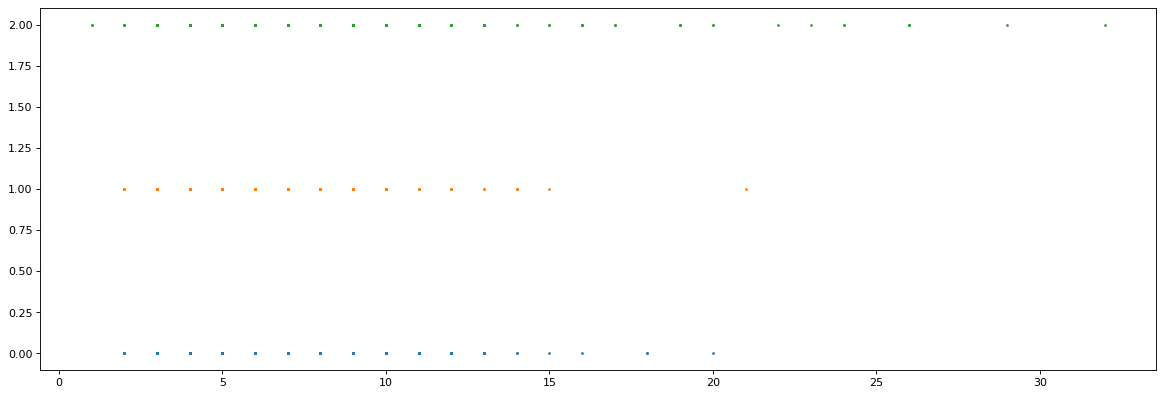

In [9]:

'''
sizes = []
for box_size in bounding_box_sizes:
    size = 1
    
    for dim in box_size:
        size *= dim
        
    sizes.append(size)
    
plt.scatter(sizes, [0] * len(sizes), s=1)'''

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(bounding_box_sizes[:, 0], [0] * len(bounding_box_sizes), s=2)
plt.scatter(bounding_box_sizes[:, 1], [1] * len(bounding_box_sizes), s=2)
plt.scatter(bounding_box_sizes[:, 2], [2] * len(bounding_box_sizes), s=2)
plt.show()

In [33]:
#check how CHUS-012 has no discernible bounding box
print(np.unique(np.load('/home/jzhe0882/numpydata/HeadNeckCancer/Mask/HN-CHUS-012.npy')))

reader = sitk.ImageFileReader()
reader.SetFileName('/home/jzhe0882/datasets/LabelMaps-Processed/HN-CHUS-012/1  RTSTRUCT  RTstruct_GTV.nrrd')
volume = reader.Execute()
array = sitk.GetArrayFromImage(volume)
print(np.unique(array))
print(bounding_box_coordinates(array))

[0]
[0]


IndexError: index 0 is out of bounds for axis 0 with size 0

# Radiomics data normalisation

In [15]:
ct_radiomics_files, pet_radiomics_files = [], []

for root, dirs, files in os.walk('/home/jzhe0882/Radiomics/' + dataset + '/CT'):
    for name in files:
        file_path = os.path.join(root, name)
        ct_radiomics_files.append(file_path)

for root, dirs, files in os.walk('/home/jzhe0882/Radiomics/' + dataset + '/PET'):
    for name in files:
        file_path = os.path.join(root, name)
        pet_radiomics_files.append(file_path)
        
def calculate_radiomics_mean_std(modality):
    #these values are derived from MyRadiomicsExtraction.ipynb
    num_features = 7
    kernel_size = 4 
    num_points = (128 / kernel_size) **3
    
    feature_sum = np.zeros(num_features, dtype=np.float64)
    feature_sum_square = np.zeros(num_features, dtype=np.float64)
    
    if modality == 'CT':
        radiomics_files = ct_radiomics_files
    elif modality == 'PET':
        radiomics_files = pet_radiomics_files
    
    for filepath in radiomics_files:
        volume = np.load(filepath)
        subsampled = volume[0::kernel_size, 0::kernel_size, 0::kernel_size, :]
        feature_sum += np.sum(subsampled, axis=(0,1,2))
        feature_sum_square = 
        print(feature_sum)
        
        return
    
calculate_radiomics_mean_std('CT')

[ 1.91250446e+12  3.59617804e+04  1.07507544e+05  1.93775938e+04
  4.39490117e+08  8.21910806e+03 -3.01149765e+07]
